In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import time
import datetime
from scipy.stats import cauchy

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import OrderedDict

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def function_sinus(amp, phase, x):
    return amp*np.sin(phase+x)

# 2D regression

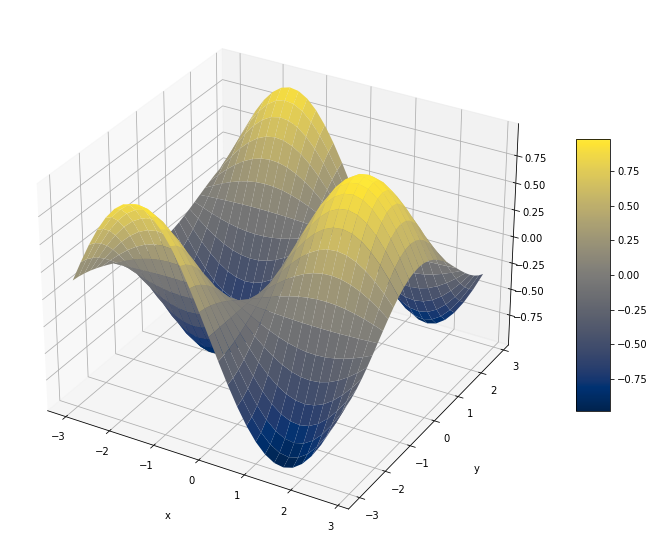

In [26]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x = np.arange(-3, 3, 0.2)
y = np.arange(-3, 3, 0.2)

X, Y = np.meshgrid(x, y)
Z = np.sin(X)*np.cos(Y)

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

# 3D sine regression (ChatGPT help)

In [16]:
def function(amp, phase, x, y):
    return amp*np.sin(phase+x+y)

#generating data
class FunctionTask():
    def __init__(self,amp,phase,min_x,max_x,min_y,max_y):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.max_y=max_y
        self.min_y=min_y
        self.amp=amp  #Amplitude
    
    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=np.random.uniform(self.max_y,self.min_y,size)
        z=self.true_function(x, y)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        z=torch.tensor(z, dtype=torch.float).unsqueeze(1)
        return torch.cat([x,y,z], dim=1)
  
    def true_function(self,x, y):
        z = function(self.amp, self.phase, x, y)
        return z
    
class FunctionDistribution():
    def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x,min_y,max_y):
        self.min_amp=min_amp
        self.max_phase=max_phase
        self.min_phase=min_phase
        self.max_amp=max_amp
        self.min_x=min_x
        self.max_x=max_x
        self.min_y=min_y
        self.max_y=max_y
    
    def sample_task(self):
        amp = np.random.uniform(self.min_amp, self.max_amp)
        phase = np.random.uniform(self.min_phase, self.max_phase)
        return FunctionTask(amp, phase, self.min_x, self.max_x, self.min_y, self.max_y)

In [2]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x,min_y,max_y = 0, 1, 0, 3.1, -5, 5, -5, 5
f = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x,min_y,max_y)

In [17]:
amp,phase,min_x,max_x,min_y,max_y = 1, 0, -5, 5, -5, 5
ftask = FunctionTask(amp,phase,min_x,max_x,min_y,max_y)

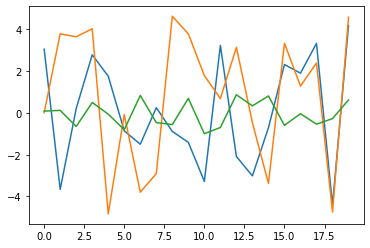

In [20]:
plt.plot(ftask.sample_data(size=20))

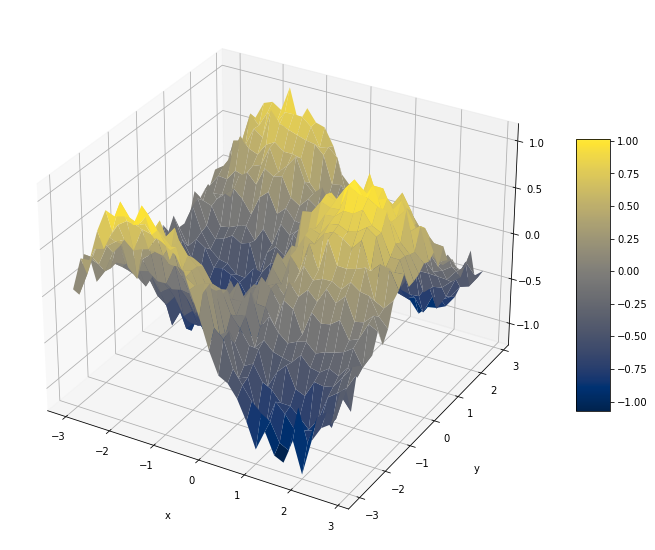

In [50]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

# Create the training data
x = np.arange(-3, 3, 0.2)
y = np.arange(-3, 3, 0.2)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)

# Add noise to simulate real data
noise = np.random.normal(0, 0.1, Z.shape)
Z += noise

# Convert data to tensors
x = torch.Tensor(x).unsqueeze(1)
y = torch.Tensor(y).unsqueeze(1)
z = torch.Tensor(z).unsqueeze(1)

# Flatten the data
x = X.flatten()
y = Y.flatten()
z = Z.flatten()

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

x = torch.from_numpy(y).float()
y = torch.from_numpy(y).float()
z = torch.from_numpy(z).float()

## Entraînement

In [111]:
print(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

-1.5 1.5 0.5 1 -5 5


In [112]:
function_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

In [113]:
function_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
net=FNet()
net=net.to(device)
maml=FMAML(net,alpha=0.01,beta=0.001,tasks=function_tasks,k=5,num_metatasks=10)

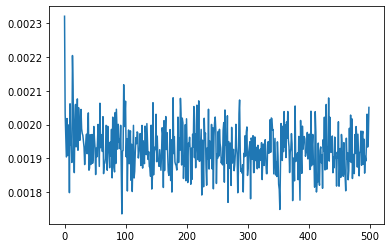

In [116]:
plt.plot(maml.meta_losses)

## Few shots

In [117]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.MSELoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y)
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

## Test

In [118]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='lower right')
  plt.show()

## Multiple plots

We plot the output for different sines, and we previously added some noise on the signal to slightly modify the outputs.

[0.044016264379024506, 0.04232938960194588, 0.040736161172389984, 0.03923097252845764, 0.037808578461408615, 0.036464083939790726, 0.03519291803240776, 0.03399079293012619, 0.032853685319423676, 0.03177785500884056]
[0.04330037534236908, 0.041924215853214264, 0.040623560547828674, 0.03939404711127281, 0.03823155164718628, 0.03713221475481987, 0.03609240800142288, 0.03510873392224312, 0.034177981317043304, 0.03329714015126228]
[0.04677792638540268, 0.04547995328903198, 0.04425329715013504, 0.04309377819299698, 0.04199749603867531, 0.040960799902677536, 0.03998023271560669, 0.039052579551935196, 0.03817480802536011, 0.0373440682888031]
[0.052083570510149, 0.051114391535520554, 0.050197016447782516, 0.04932836443185806, 0.04850556701421738, 0.04772591218352318, 0.0469869002699852, 0.04628615826368332, 0.04562146216630936, 0.044990748167037964]
[0.04738674312829971, 0.04660937190055847, 0.04587296396493912, 0.04517507180571556, 0.044513408094644547, 0.04388583451509476, 0.04329033941030502

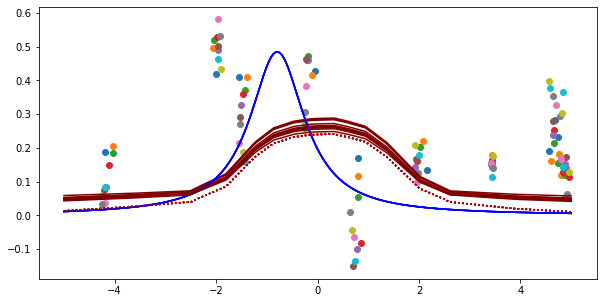

In [122]:
K=10
num_iterations = 10

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]
for i in range(num_iterations):
    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='lower right')

output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

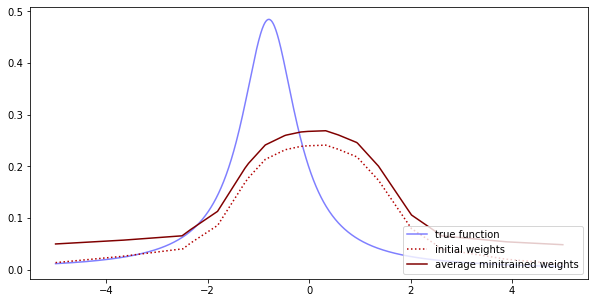

In [123]:
plt.figure(figsize=(10,5))
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
#plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), output_sum, '-', color=(0.5, 0, 0, 1), label='average minitrained weights')
plt.legend(loc='lower right')

In [121]:
#num_iterations = 100
loss = []
K=10
og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.1

for num_iterations in range(1,100):
    output_sum = [0 for i in range(1000)]
    out = []
    for i in range(num_iterations):
        x = x + epsilon*torch.randn(1, K, 1)
        y= y + epsilon*torch.randn(1, K, 1)
        outputs,axis=test(og_net,x,y,lr,optim)
        for k in range(1000):
            output_sum[k] += (outputs['minitrained'][k])
    output_sum = (np.array(output_sum)/num_iterations).tolist()

    for i in range(len(output_sum)):
        out.append(output_sum[i][0])
    temp_loss = np.linalg.norm(np.array(out)- task.true_function(axis.cpu().clone().numpy()))
    if temp_loss<100:
        loss.append(temp_loss)
    else:
        print("Problem")

[0.023552924394607544, 0.022874653339385986, 0.022229935973882675, 0.021616989746689796, 0.021034128963947296, 0.020479759201407433, 0.019952384755015373, 0.019450586289167404, 0.01897302083671093, 0.01851843297481537]
[0.03299983963370323, 0.03239288181066513, 0.03181564435362816, 0.03126657381653786, 0.03074418380856514, 0.030247066169977188, 0.029773905873298645, 0.029323454946279526, 0.028894534334540367, 0.028486022725701332]
[0.041447483003139496, 0.04081176593899727, 0.040210381150245667, 0.03964141011238098, 0.039103034883737564, 0.038593560457229614, 0.038111362606287, 0.03765493631362915, 0.037222862243652344, 0.03681378811597824]
[0.058722563087940216, 0.058458488434553146, 0.05820552259683609, 0.05796307325363159, 0.05773063749074936, 0.057507675141096115, 0.05729370564222336, 0.057088278234004974, 0.056890957057476044, 0.05670134350657463]
[0.07719917595386505, 0.07701665163040161, 0.07684038579463959, 0.0766700953245163, 0.07650548219680786, 0.07634629309177399, 0.0761922

[0.5835703015327454, 0.5781741142272949, 0.573110818862915, 0.5683566331863403, 0.5638899207115173, 0.5596907734870911, 0.5557408332824707, 0.5520235300064087, 0.5485232472419739, 0.5452257394790649]
[0.5113096833229065, 0.5088890790939331, 0.5066074132919312, 0.50445556640625, 0.5024250149726868, 0.5005077123641968, 0.498696506023407, 0.4969845712184906, 0.49536561965942383, 0.4938337206840515]
[0.49257129430770874, 0.49052825570106506, 0.4885905385017395, 0.4867513179779053, 0.4850045144557953, 0.48334431648254395, 0.48176518082618713, 0.4802621901035309, 0.47883063554763794, 0.4774661660194397]
[0.5019438862800598, 0.5009368658065796, 0.4999621510505676, 0.49901753664016724, 0.49810129404067993, 0.4972117841243744, 0.4963473379611969, 0.49550652503967285, 0.4946877956390381, 0.4938897490501404]
[0.48895445466041565, 0.4883677363395691, 0.4877978265285492, 0.48724374175071716, 0.48670443892478943, 0.48617905378341675, 0.4856666624546051, 0.48516640067100525, 0.48467761278152466, 0.48

[1.368088960647583, 1.356919288635254, 1.3463637828826904, 1.3363839387893677, 1.3269431591033936, 1.3180071115493774, 1.3095437288284302, 1.301522970199585, 1.2939163446426392, 1.2866973876953125]
[1.4117110967636108, 1.3984602689743042, 1.3859785795211792, 1.3742181062698364, 1.3631349802017212, 1.352687120437622, 1.3428350687026978, 1.333541750907898, 1.3247720003128052, 1.3164927959442139]
[1.5266287326812744, 1.511366605758667, 1.496988296508789, 1.4834403991699219, 1.4706727266311646, 1.4586384296417236, 1.4472877979278564, 1.4365479946136475, 1.426413893699646, 1.416848063468933]
[1.4996083974838257, 1.484756350517273, 1.4707614183425903, 1.4575729370117188, 1.4451444149017334, 1.4334309101104736, 1.4223899841308594, 1.4119818210601807, 1.4021682739257812, 1.3929132223129272]
[1.4934046268463135, 1.4807616472244263, 1.4688513278961182, 1.4576300382614136, 1.4470574855804443, 1.4370946884155273, 1.4277055263519287, 1.4188549518585205, 1.4105098247528076, 1.4026398658752441]
[1.38

[1.8578557968139648, 1.8564586639404297, 1.8550885915756226, 1.8537423610687256, 1.8524153232574463, 1.8511054515838623, 1.8498092889785767, 1.8485238552093506, 1.847246766090393, 1.8459755182266235]
[2.0983238220214844, 2.096792459487915, 2.095299482345581, 2.0938405990600586, 2.092412233352661, 2.091010332107544, 2.0896313190460205, 2.0882718563079834, 2.0869297981262207, 2.085601568222046]
[1.9276262521743774, 1.9260543584823608, 1.9245132207870483, 1.923000693321228, 1.921513319015503, 1.9200481176376343, 1.9186025857925415, 1.917173981666565, 1.915759801864624, 1.9143575429916382]
[2.0813376903533936, 2.0796730518341064, 2.078063488006592, 2.0765042304992676, 2.074990749359131, 2.0735185146331787, 2.0720832347869873, 2.070681571960449, 2.069309711456299, 2.0679640769958496]
[1.837419867515564, 1.8354673385620117, 1.8335822820663452, 1.831756353378296, 1.8300209045410156, 1.828510046005249, 1.827044129371643, 1.8256183862686157, 1.8242288827896118, 1.8228704929351807]
[1.9643179178

[2.7468411922454834, 2.7329421043395996, 2.720170497894287, 2.7083680629730225, 2.6973986625671387, 2.687145233154297, 2.6775057315826416, 2.668618679046631, 2.6605935096740723, 2.652888536453247]
[2.70271635055542, 2.6898088455200195, 2.677743434906006, 2.666388511657715, 2.6561267375946045, 2.6478142738342285, 2.639805316925049, 2.632070779800415, 2.6245832443237305, 2.617316722869873]
[2.5780956745147705, 2.5649161338806152, 2.552736520767212, 2.5414206981658936, 2.530851364135742, 2.520927667617798, 2.511561632156372, 2.503091335296631, 2.495485782623291, 2.4881739616394043]
[2.539454698562622, 2.526710271835327, 2.5149827003479004, 2.504135847091675, 2.494053840637207, 2.484636068344116, 2.4757955074310303, 2.467456102371216, 2.4595518112182617, 2.452022075653076]
[2.560379981994629, 2.545769214630127, 2.5323896408081055, 2.5200705528259277, 2.508665084838867, 2.49804949760437, 2.4881153106689453, 2.4793145656585693, 2.471402168273926, 2.4638633728027344]
[2.731628894805908, 2.716

[3.375502109527588, 3.348816394805908, 3.3246822357177734, 3.302783966064453, 3.2828545570373535, 3.264665126800537, 3.2480225563049316, 3.232755184173584, 3.218719959259033, 3.2057881355285645]
[3.431642532348633, 3.401731491088867, 3.374720811843872, 3.3502488136291504, 3.3280105590820312, 3.3077476024627686, 3.289238691329956, 3.272294282913208, 3.256748914718628, 3.2424607276916504]
[3.5614471435546875, 3.530076265335083, 3.5017476081848145, 3.4760775566101074, 3.4527478218078613, 3.4314823150634766, 3.412050724029541, 3.3942532539367676, 3.377917528152466, 3.362894058227539]
[3.454387664794922, 3.4196536540985107, 3.3883204460144043, 3.359954357147217, 3.334190845489502, 3.3107235431671143, 3.2892918586730957, 3.2696728706359863, 3.251673460006714, 3.235128879547119]
[3.4086124897003174, 3.3708019256591797, 3.336683988571167, 3.3057804107666016, 3.277691602706909, 3.2520816326141357, 3.228665590286255, 3.2072014808654785, 3.18748140335083, 3.169325590133667]
[3.457979679107666, 3.

[3.1490299701690674, 3.123366594314575, 3.100238800048828, 3.0793042182922363, 3.0602731704711914, 3.042901039123535, 3.026979446411133, 3.0123274326324463, 2.9987905025482178, 2.986234426498413]
[3.175455331802368, 3.15057110786438, 3.1281514167785645, 3.1078598499298096, 3.089411735534668, 3.07256817817688, 3.0571227073669434, 3.042898654937744, 3.0297446250915527, 3.017526149749756]
[3.1773998737335205, 3.150664806365967, 3.126574993133545, 3.104766845703125, 3.084932565689087, 3.066812038421631, 3.0501835346221924, 3.0348572731018066, 3.0206685066223145, 3.0074758529663086]
[3.2279250621795654, 3.203699827194214, 3.1819047927856445, 3.1622061729431152, 3.1443216800689697, 3.1280126571655273, 3.1130762100219727, 3.099336862564087, 3.086643695831299, 3.0748658180236816]
[3.492992401123047, 3.467228651046753, 3.4441113471984863, 3.423266649246216, 3.404379367828369, 3.3871841430664062, 3.371454954147339, 3.356999635696411, 3.343649387359619, 3.331261157989502]
[3.329176425933838, 3.30

[6.450636386871338, 6.3672075271606445, 6.294307231903076, 6.229763984680176, 6.171875953674316, 6.119287014007568, 6.070908069610596, 6.0258307456970215, 5.9832916259765625, 5.9426374435424805]
[6.621097564697266, 6.528513431549072, 6.448101043701172, 6.377225399017334, 6.3138556480407715, 6.256397247314453, 6.203574180603027, 6.154349327087402, 6.107863903045654, 6.06339693069458]
[6.503147125244141, 6.39847469329834, 6.307494163513184, 6.2272047996521, 6.155312538146973, 6.090034484863281, 6.029958724975586, 5.973945617675781, 5.9210638999938965, 5.870539665222168]
[6.30718994140625, 6.195532321929932, 6.098456382751465, 6.012745380401611, 5.935962677001953, 5.866221904754639, 5.802037715911865, 5.742222309112549, 5.685814380645752, 5.632022857666016]
[6.121664524078369, 6.0030622482299805, 5.899702072143555, 5.808232307434082, 5.726115703582764, 5.651400566101074, 5.582553863525391, 5.518359184265137, 5.457835674285889, 5.400184154510498]
[5.935711860656738, 5.812742233276367, 5.70

[7.271568298339844, 7.224957466125488, 7.1836090087890625, 7.146634578704834, 7.1133012771606445, 7.083006381988525, 7.055248260498047, 7.02959680557251, 7.005687713623047, 6.983199119567871]
[6.851614952087402, 6.813591003417969, 6.779838562011719, 6.7496657371521, 6.722502708435059, 6.697872161865234, 6.6753692626953125, 6.6546502113342285, 6.6354193687438965, 6.617415428161621]
[7.00994348526001, 6.972113132476807, 6.938539028167725, 6.908518314361572, 6.8814697265625, 6.856903076171875, 6.834406852722168, 6.813620567321777, 6.794234275817871, 6.775970458984375]
[6.975377559661865, 6.9398674964904785, 6.908297061920166, 6.880002021789551, 6.854422569274902, 6.831087589263916, 6.8095879554748535, 6.789568901062012, 6.770713806152344, 6.752734184265137]
[7.051766872406006, 7.01483154296875, 6.982093811035156, 6.9528350830078125, 6.926453590393066, 6.902444362640381, 6.880373477935791, 6.85985803604126, 6.840566158294678, 6.8221917152404785]
[7.216040134429932, 7.179187774658203, 7.146

[5.63840389251709, 5.568560600280762, 5.506165981292725, 5.449639797210693, 5.397635459899902, 5.348967552185059, 5.302556991577148, 5.257381439208984, 5.21243953704834, 5.166718482971191]
[5.773561000823975, 5.697827339172363, 5.630267143249512, 5.569096565246582, 5.512803077697754, 5.460058689117432, 5.409653663635254, 5.360443592071533, 5.31130313873291, 5.261083602905273]
[6.054657459259033, 5.967189788818359, 5.889315605163574, 5.818869113922119, 5.754022121429443, 5.693178176879883, 5.634883403778076, 5.577759742736816, 5.520444393157959, 5.461539268493652]
[6.070533752441406, 5.997982025146484, 5.933183193206787, 5.874320030212402, 5.8198323249816895, 5.768333435058594, 5.718539237976074, 5.669206619262695, 5.619089603424072, 5.566893577575684]
[6.292853355407715, 6.212690353393555, 6.1412224769592285, 6.07639217376709, 6.016448497772217, 5.959836006164551, 5.90511417388916, 5.850889682769775, 5.795747756958008, 5.738213539123535]
[6.4249138832092285, 6.3481340408325195, 6.27939

[8.524868965148926, 8.467280387878418, 8.416840553283691, 8.369070053100586, 8.32009220123291, 8.266084671020508, 8.202840805053711, 8.125365257263184, 8.027477264404297, 7.901449680328369]
[8.827791213989258, 8.77222728729248, 8.723608016967773, 8.677499771118164, 8.630049705505371, 8.577457427978516, 8.515520095825195, 8.439230918884277, 8.34237289428711, 8.217157363891602]
[8.799324035644531, 8.745901107788086, 8.699335098266602, 8.655501365661621, 8.610834121704102, 8.561848640441895, 8.504721641540527, 8.43492317199707, 8.346874237060547, 8.233566284179688]
[9.384031295776367, 9.32601547241211, 9.275388717651367, 9.227697372436523, 9.179100036621094, 9.125807762145996, 9.063634872436523, 8.987588882446289, 8.891427993774414, 8.767217636108398]
[9.269857406616211, 9.214330673217773, 9.16588020324707, 9.120295524597168, 9.073951721191406, 9.023295402526855, 8.964425086975098, 8.89267349243164, 8.80224895477295, 8.685887336730957]
[9.070920944213867, 9.019652366638184, 8.974874496459

[10.119502067565918, 10.090052604675293, 10.06556510925293, 10.043657302856445, 10.02232551574707, 9.999853134155273, 9.974461555480957, 9.944093704223633, 9.906204223632812, 9.85750961303711]
[9.824052810668945, 9.794486999511719, 9.769800186157227, 9.74752140045166, 9.725664138793945, 9.702404975891113, 9.675847053527832, 9.643790245056152, 9.603487014770508, 9.551393508911133]
[10.099569320678711, 10.068069458007812, 10.04164981842041, 10.017805099487305, 9.994511604309082, 9.969924926757812, 9.942124366760254, 9.908875465393066, 9.867382049560547, 9.814033508300781]
[9.854101181030273, 9.823576927185059, 9.797820091247559, 9.774518966674805, 9.751802444458008, 9.727965354919434, 9.701250076293945, 9.66964340209961, 9.630659103393555, 9.581121444702148]
[9.77552318572998, 9.747408866882324, 9.723673820495605, 9.702299118041992, 9.681668281555176, 9.660321235656738, 9.63679313659668, 9.609428405761719, 9.57622241973877, 9.534612655639648]
[9.898685455322266, 9.870586395263672, 9.8469

[14.517946243286133, 14.465983390808105, 14.423507690429688, 14.383703231811523, 14.34088134765625, 14.28936767578125, 14.222326278686523, 14.130938529968262, 14.004968643188477, 13.828173637390137]
[14.505404472351074, 14.446894645690918, 14.398664474487305, 14.353143692016602, 14.303993225097656, 14.244756698608398, 14.167966842651367, 14.064518928527832, 13.921099662780762, 13.719917297363281]
[14.443304061889648, 14.389472961425781, 14.345067977905273, 14.303375244140625, 14.258665084838867, 14.205404281616211, 14.13695240020752, 14.044690132141113, 13.91700553894043, 13.738197326660156]
[14.406211853027344, 14.350934982299805, 14.305102348327637, 14.262001037597656, 14.216018676757812, 14.16149616241455, 14.091771125793457, 13.998291015625, 13.869497299194336, 13.689555168151855]
[14.439468383789062, 14.385540962219238, 14.341634750366211, 14.299955368041992, 14.253969192504883, 14.19697093963623, 14.120895385742188, 14.015130996704102, 13.865094184875488, 13.651056289672852]
[14.

[17.874549865722656, 17.801864624023438, 17.74179458618164, 17.682477951049805, 17.613677978515625, 17.524303436279297, 17.40020751953125, 17.221961975097656, 16.96206283569336, 16.579065322875977]
[17.809656143188477, 17.73440933227539, 17.671852111816406, 17.609783172607422, 17.53763771057129, 17.443904876708984, 17.31389617919922, 17.127370834350586, 16.8557071685791, 16.452594757080078]
[17.83848762512207, 17.75850486755371, 17.691585540771484, 17.624723434448242, 17.54656410217285, 17.444644927978516, 17.303037643432617, 17.09987449645996, 16.800321578979492, 16.307451248168945]
[17.38033676147461, 17.302051544189453, 17.2363338470459, 17.17040252685547, 17.093029022216797, 16.99192237854004, 16.851459503173828, 16.650325775146484, 16.35883331298828, 15.914560317993164]
[17.295087814331055, 17.21980094909668, 17.15653419494629, 17.093412399291992, 17.02003288269043, 16.92511558532715, 16.794462203979492, 16.608747482299805, 16.341154098510742, 15.941650390625]
[16.90186882019043, 

[15.51007080078125, 15.441418647766113, 15.382654190063477, 15.326006889343262, 15.264918327331543, 15.192558288574219, 15.100553512573242, 14.977609634399414, 14.80792236328125, 14.569192886352539]
[15.36461353302002, 15.297338485717773, 15.23987102508545, 15.18431568145752, 15.1239652633667, 15.05180549621582, 14.959226608276367, 14.834612846374512, 14.661715507507324, 14.417696952819824]
[15.389386177062988, 15.323718070983887, 15.267433166503906, 15.213412284851074, 15.155660629272461, 15.087991714477539, 15.002924919128418, 14.890497207641602, 14.736871719360352, 14.522638320922852]
[14.6094331741333, 14.54621696472168, 14.491943359375, 14.440042495727539, 14.385015487670898, 14.321243286132812, 14.242037773132324, 14.13860034942627, 13.998873710632324, 13.806085586547852]
[14.757311820983887, 14.693258285522461, 14.63818359375, 14.585322380065918, 14.528938293457031, 14.463170051574707, 14.380979537963867, 14.273122787475586, 14.126916885375977, 13.924786567687988]
[14.7071123123

[11.968852996826172, 11.90455436706543, 11.84791374206543, 11.794431686401367, 11.740432739257812, 11.682419776916504, 11.61656665802002, 11.538249969482422, 11.441570281982422, 11.318861961364746]
[12.176396369934082, 12.105923652648926, 12.04389762878418, 11.985006332397461, 11.924890518188477, 11.859335899353027, 11.783501625061035, 11.691587448120117, 11.576078414916992, 11.4271821975708]
[12.451355934143066, 12.38117504119873, 12.319530487060547, 12.260839462280273, 12.200488090515137, 12.133980751037598, 12.056234359741211, 11.960943222045898, 11.839923858642578, 11.682443618774414]
[12.403547286987305, 12.326372146606445, 12.258554458618164, 12.19355583190918, 12.12595272064209, 12.050390243530273, 11.960739135742188, 11.849334716796875, 11.706225395202637, 11.518453598022461]
[12.477614402770996, 12.400186538696289, 12.332159042358398, 12.267311096191406, 12.200550079345703, 12.126897811889648, 12.040691375732422, 11.934845924377441, 11.800111770629883, 11.624334335327148]
[12.

[11.10710334777832, 11.052973747253418, 11.004205703735352, 10.957433700561523, 10.909821510314941, 10.858698844909668, 10.801275253295898, 10.734063148498535, 10.653494834899902, 10.555234909057617]
[11.28785514831543, 11.234457015991211, 11.186488151550293, 11.1405611038208, 11.093801498413086, 11.04348087310791, 10.986745834350586, 10.92037582397461, 10.840689659118652, 10.743831634521484]
[11.309652328491211, 11.263517379760742, 11.221839904785156, 11.182194709777832, 11.142523765563965, 11.100930213928223, 11.055435180664062, 11.003687858581543, 10.943291664123535, 10.874215126037598]
[11.083884239196777, 11.036368370056152, 10.993391036987305, 10.952461242675781, 10.911473274230957, 10.868484497070312, 10.821540832519531, 10.768527030944824, 10.707259178161621, 10.636033058166504]
[11.29468822479248, 11.248250961303711, 11.206114768981934, 11.165966987609863, 11.12586784362793, 11.084047317504883, 11.038740158081055, 10.988081932067871, 10.930018424987793, 10.864169120788574]
[11

[13.792398452758789, 13.764404296875, 13.738588333129883, 13.714372634887695, 13.691305160522461, 13.669008255004883, 13.647163391113281, 13.625468254089355, 13.603639602661133, 13.58137035369873]
[14.30384349822998, 14.273706436157227, 14.246095657348633, 14.2202730178833, 14.195657730102539, 14.17176628112793, 14.148183822631836, 14.124513626098633, 14.100354194641113, 14.075284957885742]
[14.310101509094238, 14.28196907043457, 14.257078170776367, 14.234779357910156, 14.214622497558594, 14.196161270141602, 14.178892135620117, 14.16267204284668, 14.147354125976562, 14.132832527160645]
[14.41480541229248, 14.386442184448242, 14.361187934875488, 14.338435173034668, 14.317764282226562, 14.298799514770508, 14.28101921081543, 14.264286994934082, 14.2484769821167, 14.233474731445312]
[14.421732902526855, 14.395868301391602, 14.371740341186523, 14.348993301391602, 14.327362060546875, 14.30665111541748, 14.286684036254883, 14.267341613769531, 14.248509407043457, 14.230093002319336]
[14.664294

[12.689512252807617, 12.686832427978516, 12.683774948120117, 12.680215835571289, 12.67600154876709, 12.670948028564453, 12.664822578430176, 12.657341957092285, 12.648147583007812, 12.636802673339844]
[12.48553466796875, 12.48231029510498, 12.478470802307129, 12.473860740661621, 12.468287467956543, 12.461503982543945, 12.453201293945312, 12.443024635314941, 12.43053150177002, 12.415731430053711]
[12.86378002166748, 12.860029220581055, 12.855466842651367, 12.849889755249023, 12.843040466308594, 12.834599494934082, 12.824177742004395, 12.811291694641113, 12.795354843139648, 12.77842903137207]
[12.704748153686523, 12.700957298278809, 12.69636344909668, 12.690755844116211, 12.683877944946289, 12.675413131713867, 12.664960861206055, 12.652030944824219, 12.636021614074707, 12.616191864013672]
[13.147893905639648, 13.144338607788086, 13.14020824432373, 13.135340690612793, 13.129534721374512, 13.122543334960938, 13.114062309265137, 13.103759765625, 13.09113597869873, 13.075616836547852]
[13.097

[13.851251602172852, 13.84704875946045, 13.843513488769531, 13.840472221374512, 13.837794303894043, 13.83537483215332, 13.833137512207031, 13.831014633178711, 13.828951835632324, 13.826898574829102]
[13.834127426147461, 13.830869674682617, 13.828015327453613, 13.825433731079102, 13.823015213012695, 13.820663452148438, 13.818296432495117, 13.815829277038574, 13.813166618347168, 13.810209274291992]
[13.698953628540039, 13.696130752563477, 13.69328784942627, 13.69031047821045, 13.68708324432373, 13.68347454071045, 13.679336547851562, 13.674489974975586, 13.668724060058594, 13.661776542663574]
[13.75151252746582, 13.748811721801758, 13.746182441711426, 13.743517875671387, 13.740710258483887, 13.737648010253906, 13.734156608581543, 13.729978561401367, 13.725118637084961, 13.719369888305664]
[13.806729316711426, 13.803451538085938, 13.800288200378418, 13.797126770019531, 13.793863296508789, 13.790392875671387, 13.786598205566406, 13.782346725463867, 13.777490615844727, 13.771835327148438]
[1

[18.24758529663086, 18.240367889404297, 18.234912872314453, 18.230670928955078, 18.22724723815918, 18.224390029907227, 18.221920013427734, 18.219722747802734, 18.217708587646484, 18.215816497802734]
[18.321813583374023, 18.315114974975586, 18.310163497924805, 18.306379318237305, 18.303377151489258, 18.30088996887207, 18.298749923706055, 18.29684066772461, 18.295066833496094, 18.293371200561523]
[18.01007843017578, 18.004180908203125, 17.999755859375, 17.996339797973633, 17.993606567382812, 17.991334915161133, 17.98935890197754, 17.987565994262695, 17.98586654663086, 17.984188079833984]
[17.976192474365234, 17.96868896484375, 17.962656021118164, 17.95765495300293, 17.953386306762695, 17.949630737304688, 17.946237564086914, 17.94310188293457, 17.940139770507812, 17.93729019165039]
[17.723934173583984, 17.717586517333984, 17.71260643005371, 17.708566665649414, 17.705158233642578, 17.702180862426758, 17.699460983276367, 17.69688606262207, 17.694339752197266, 17.691722869873047]
[17.9748172

[16.23577880859375, 16.22239875793457, 16.209714889526367, 16.19767951965332, 16.185901641845703, 16.174259185791016, 16.16263198852539, 16.150928497314453, 16.13992691040039, 16.129241943359375]
[16.282623291015625, 16.269287109375, 16.256855010986328, 16.244924545288086, 16.233354568481445, 16.222003936767578, 16.210773468017578, 16.19955825805664, 16.18827247619629, 16.176822662353516]
[15.85193157196045, 15.838621139526367, 15.826040267944336, 15.81402587890625, 15.80224323272705, 15.790571212768555, 15.778890609741211, 15.767138481140137, 15.755180358886719, 15.742874145507812]
[16.21276092529297, 16.198471069335938, 16.18499183654785, 16.17209243774414, 16.159685134887695, 16.14746856689453, 16.135313034057617, 16.123111724853516, 16.110755920410156, 16.098125457763672]
[16.376850128173828, 16.3646240234375, 16.352691650390625, 16.340923309326172, 16.328907012939453, 16.316452026367188, 16.30338478088379, 16.2894287109375, 16.27431869506836, 16.25773048400879]
[16.369346618652344

[18.208017349243164, 18.192440032958984, 18.17644691467285, 18.159345626831055, 18.14065933227539, 18.119775772094727, 18.095930099487305, 18.068143844604492, 18.035181045532227, 17.99555015563965]
[17.978221893310547, 17.96255111694336, 17.946056365966797, 17.928264617919922, 17.90919303894043, 17.887836456298828, 17.863460540771484, 17.835071563720703, 17.80144500732422, 17.761051177978516]
[17.918142318725586, 17.9020938873291, 17.884965896606445, 17.866640090942383, 17.846281051635742, 17.82320213317871, 17.796520233154297, 17.765125274658203, 17.727632522583008, 17.68239974975586]
[18.1905517578125, 18.170984268188477, 18.14982032775879, 18.12667465209961, 18.10115623474121, 18.072078704833984, 18.03831672668457, 17.998456954956055, 17.950748443603516, 17.89306640625]
[18.905729293823242, 18.88606071472168, 18.864803314208984, 18.84128761291504, 18.814754486083984, 18.78502082824707, 18.750307083129883, 18.70905876159668, 18.659339904785156, 18.598770141601562]
[18.67940902709961,

[18.56679916381836, 18.559141159057617, 18.552255630493164, 18.545995712280273, 18.54024887084961, 18.534915924072266, 18.52992057800293, 18.525196075439453, 18.520687103271484, 18.516355514526367]
[19.04161834716797, 19.034069061279297, 19.02729606628418, 19.021154403686523, 19.015520095825195, 19.010286331176758, 19.00537872314453, 19.000728607177734, 18.996278762817383, 18.99197006225586]
[19.12871742248535, 19.122142791748047, 19.11618423461914, 19.1107120513916, 19.105621337890625, 19.1008358001709, 19.096277236938477, 19.09187889099121, 19.087589263916016, 19.08333969116211]
[18.919109344482422, 18.912670135498047, 18.906951904296875, 18.90180015563965, 18.897113800048828, 18.892803192138672, 18.888784408569336, 18.884998321533203, 18.881399154663086, 18.8779354095459]
[19.011463165283203, 19.002225875854492, 18.99422264099121, 18.98719596862793, 18.98094367980957, 18.975313186645508, 18.97016716003418, 18.96539878845215, 18.960918426513672, 18.95665740966797]
[19.05052375793457,

[18.570858001708984, 18.55535316467285, 18.541345596313477, 18.52857208251953, 18.516817092895508, 18.505905151367188, 18.495697021484375, 18.486093521118164, 18.477005004882812, 18.46835708618164]
[19.04303550720215, 19.026391983032227, 19.011455535888672, 18.997905731201172, 18.985485076904297, 18.973997116088867, 18.963275909423828, 18.95319366455078, 18.943653106689453, 18.93456268310547]
[18.994815826416016, 18.981029510498047, 18.968631744384766, 18.957361221313477, 18.947021484375, 18.937448501586914, 18.928518295288086, 18.920133590698242, 18.91220474243164, 18.904682159423828]
[19.576860427856445, 19.56532859802246, 19.554441452026367, 19.54402732849121, 19.53394317626953, 19.524049758911133, 19.514209747314453, 19.504283905029297, 19.494115829467773, 19.483537673950195]
[19.98091697692871, 19.970439910888672, 19.959915161132812, 19.949176788330078, 19.937976837158203, 19.926067352294922, 19.913150787353516, 19.89886474609375, 19.88277816772461, 19.864299774169922]
[19.9256095

[22.093677520751953, 22.085277557373047, 22.074682235717773, 22.060733795166016, 22.042224884033203, 22.017553329467773, 21.984485626220703, 21.94044303894043, 21.88425064086914, 21.81435775756836]
[22.19253921508789, 22.18241310119629, 22.169260025024414, 22.151165008544922, 22.12613868713379, 22.091476440429688, 22.04358673095703, 21.979204177856445, 21.89620590209961, 21.787425994873047]
[22.861408233642578, 22.85222816467285, 22.840534210205078, 22.824668884277344, 22.802959442138672, 22.77310562133789, 22.732471466064453, 22.680335998535156, 22.611059188842773, 22.520076751708984]
[23.04741668701172, 23.03485679626465, 23.018756866455078, 22.996807098388672, 22.966691970825195, 22.925334930419922, 22.86931610107422, 22.79804039001465, 22.70455551147461, 22.583866119384766]
[22.671184539794922, 22.658763885498047, 22.64271354675293, 22.62094497680664, 22.591222763061523, 22.550552368164062, 22.495044708251953, 22.422632217407227, 22.330488204956055, 22.212085723876953]
[22.91930389

[21.96426773071289, 21.92123794555664, 21.869037628173828, 21.802898406982422, 21.7172908782959, 21.605865478515625, 21.461532592773438, 21.277774810791016, 21.049991607666016, 20.82345199584961]
[22.170942306518555, 22.123741149902344, 22.066436767578125, 21.993452072143555, 21.89845848083496, 21.77341651916504, 21.611736297607422, 21.407167434692383, 21.156681060791016, 20.91697883605957]
[22.21352767944336, 22.17347526550293, 22.12484359741211, 22.063236236572266, 21.98352813720703, 21.87980842590332, 21.745601654052734, 21.574644088745117, 21.362712860107422, 21.12427520751953]
[21.871980667114258, 21.835224151611328, 21.791078567504883, 21.73589324951172, 21.665390014648438, 21.574542999267578, 21.457714080810547, 21.309083938598633, 21.124109268188477, 20.901973724365234]
[21.49085235595703, 21.45973777770996, 21.422277450561523, 21.375587463378906, 21.31619644165039, 21.23991584777832, 21.14195442199707, 21.01717758178711, 20.86073112487793, 20.669723510742188]
[21.1465625762939

[20.12614631652832, 20.09888458251953, 20.069705963134766, 20.037982940673828, 20.002994537353516, 19.963878631591797, 19.919681549072266, 19.8692569732666, 19.81134033203125, 19.744735717773438]
[20.263858795166016, 20.238567352294922, 20.212154388427734, 20.184219360351562, 20.154314041137695, 20.12190818786621, 20.086376190185547, 20.047012329101562, 20.00296401977539, 19.953271865844727]
[19.596946716308594, 19.57072639465332, 19.543563842773438, 19.515165328979492, 19.485143661499023, 19.453025817871094, 19.41827392578125, 19.38024139404297, 19.33816909790039, 19.29132080078125]
[19.711111068725586, 19.684314727783203, 19.65706443786621, 19.629154205322266, 19.600303649902344, 19.570194244384766, 19.538455963134766, 19.50466537475586, 19.468334197998047, 19.428936004638672]
[19.976572036743164, 19.95165252685547, 19.92604637145996, 19.899417877197266, 19.871437072753906, 19.841705322265625, 19.80975341796875, 19.77503776550293, 19.736919403076172, 19.694686889648438]
[20.089578628

[20.600584030151367, 20.580833435058594, 20.55997085571289, 20.537616729736328, 20.513410568237305, 20.486915588378906, 20.457637786865234, 20.425029754638672, 20.388513565063477, 20.34757423400879]
[20.91657066345215, 20.896207809448242, 20.874378204345703, 20.850643157958984, 20.824466705322266, 20.795177459716797, 20.76212501525879, 20.724634170532227, 20.681989669799805, 20.633691787719727]
[21.19283103942871, 21.17117691040039, 21.147600173950195, 21.121402740478516, 21.09185218811035, 21.058055877685547, 21.019105911254883, 20.97384262084961, 20.921483993530273, 20.861358642578125]
[21.355566024780273, 21.33429527282715, 21.31097412109375, 21.28487777709961, 21.255233764648438, 21.221168518066406, 21.181743621826172, 21.135976791381836, 21.082883834838867, 21.021940231323242]
[21.468345642089844, 21.446874618530273, 21.423358917236328, 21.396936416625977, 21.36679458618164, 21.332073211669922, 21.291746139526367, 21.24464988708496, 21.189607620239258, 21.126800537109375]
[21.2950

[21.72051429748535, 21.682870864868164, 21.63787841796875, 21.581138610839844, 21.508642196655273, 21.41609764099121, 21.300243377685547, 21.159236907958984, 20.994983673095703, 20.814252853393555]
[22.149154663085938, 22.11235809326172, 22.0678768157959, 22.011150360107422, 21.937570571899414, 21.842426300048828, 21.72166633605957, 21.572614669799805, 21.395910263061523, 21.198549270629883]
[21.920928955078125, 21.88203239440918, 21.834699630737305, 21.77379035949707, 21.694143295288086, 21.590576171875, 21.45870590209961, 21.295963287353516, 21.104183197021484, 20.892101287841797]
[22.025632858276367, 21.990314483642578, 21.947582244873047, 21.892902374267578, 21.821821212768555, 21.729778289794922, 21.61281967163086, 21.468196868896484, 21.296451568603516, 21.104225158691406]
[21.719879150390625, 21.68471908569336, 21.641559600830078, 21.585908889770508, 21.513565063476562, 21.419370651245117, 21.298887252807617, 21.149234771728516, 20.970151901245117, 20.76834487915039]
[21.8146057

[20.320720672607422, 20.264808654785156, 20.202655792236328, 20.13036346435547, 20.044485092163086, 19.94203758239746, 19.821102142333984, 19.681230545043945, 19.52513885498047, 19.35883331298828]
[19.938026428222656, 19.88705825805664, 19.830341339111328, 19.76437759399414, 19.68622398376465, 19.59292221069336, 19.482376098632812, 19.354087829589844, 19.20981788635254, 19.054269790649414]
[20.198955535888672, 20.145153045654297, 20.085399627685547, 20.016033172607422, 19.93405532836914, 19.8363094329834, 19.72089958190918, 19.586997985839844, 19.436681747436523, 19.275279998779297]
[20.332548141479492, 20.281497955322266, 20.224790573120117, 20.159015655517578, 20.08126449584961, 19.98853874206543, 19.878582000732422, 19.750667572021484, 19.60602378845215, 19.449146270751953]
[20.47890281677246, 20.41948127746582, 20.35277557373047, 20.274227142333984, 20.179882049560547, 20.065942764282227, 19.929920196533203, 19.771753311157227, 19.594837188720703, 19.407325744628906]
[19.9883728027

[21.160430908203125, 21.10000228881836, 21.039194107055664, 20.974971771240234, 20.90652084350586, 20.833005905151367, 20.75456428527832, 20.67142677307129, 20.584583282470703, 20.485549926757812]
[21.357017517089844, 21.289417266845703, 21.220745086669922, 21.147531509399414, 21.068653106689453, 20.983278274536133, 20.891530990600586, 20.794836044311523, 20.69514274597168, 20.59621810913086]
[21.4471492767334, 21.383907318115234, 21.320053100585938, 21.252723693847656, 21.181018829345703, 21.104108810424805, 21.02184295654297, 20.934894561767578, 20.84427261352539, 20.751497268676758]
[21.79755973815918, 21.738645553588867, 21.678607940673828, 21.61446762084961, 21.54515266418457, 21.470121383666992, 21.389184951782227, 21.302875518798828, 21.21253204345703, 21.12190818786621]
[21.844289779663086, 21.784805297851562, 21.72416877746582, 21.659513473510742, 21.589557647705078, 21.513614654541016, 21.431865692138672, 21.344953536987305, 21.254140853881836, 21.16409683227539]
[21.44234848

[24.878902435302734, 24.779922485351562, 24.678905487060547, 24.57424545288086, 24.464494705200195, 24.349523544311523, 24.228599548339844, 24.10177230834961, 23.969573974609375, 23.832599639892578]
[25.044090270996094, 24.953750610351562, 24.86212921142578, 24.766651153564453, 24.667842864990234, 24.56447982788086, 24.456180572509766, 24.342796325683594, 24.224567413330078, 24.102087020874023]
[25.506723403930664, 25.412174224853516, 25.317466735839844, 25.219852447509766, 25.118534088134766, 25.012893676757812, 24.90256690979004, 24.7874698638916, 24.666704177856445, 24.532386779785156]
[25.722909927368164, 25.625131607055664, 25.527692794799805, 25.42801284790039, 25.325353622436523, 25.219139099121094, 25.108320236206055, 24.98933982849121, 24.865283966064453, 24.73628807067871]
[25.978958129882812, 25.877216339111328, 25.775104522705078, 25.669912338256836, 25.560810089111328, 25.447036743164062, 25.328006744384766, 25.203258514404297, 25.063671112060547, 24.915719985961914]
[26.3

[26.434894561767578, 26.324657440185547, 26.212909698486328, 26.095767974853516, 25.971668243408203, 25.84006118774414, 25.700031280517578, 25.55105972290039, 25.39577865600586, 25.236671447753906]
[26.781230926513672, 26.67315101623535, 26.56363868713379, 26.449146270751953, 26.32821273803711, 26.199655532836914, 26.06216812133789, 25.9162540435791, 25.7640380859375, 25.607131958007812]
[26.484195709228516, 26.390151977539062, 26.29550552368164, 26.197589874267578, 26.095569610595703, 25.98868179321289, 25.87636375427246, 25.757781982421875, 25.634296417236328, 25.50649642944336]
[26.93813133239746, 26.842758178710938, 26.74636459350586, 26.645727157592773, 26.539562225341797, 26.426830291748047, 26.306095123291016, 26.179744720458984, 26.04738426208496, 25.90964126586914]
[27.584396362304688, 27.4842529296875, 27.38285255432129, 27.276559829711914, 27.163867950439453, 27.0434627532959, 26.914831161499023, 26.778762817382812, 26.61600685119629, 26.44441795349121]
[27.901123046875, 27.

[24.822513580322266, 24.688138961791992, 24.542007446289062, 24.375402450561523, 24.183208465576172, 23.97198486328125, 23.735157012939453, 23.47285270690918, 23.185937881469727, 22.882061004638672]
[25.357324600219727, 25.21548080444336, 25.058565139770508, 24.876306533813477, 24.661714553833008, 24.42426300048828, 24.1602840423584, 23.868101119995117, 23.55055046081543, 23.206483840942383]
[25.18340492248535, 25.047077178955078, 24.896177291870117, 24.723052978515625, 24.53274917602539, 24.317218780517578, 24.074941635131836, 23.8054141998291, 23.510780334472656, 23.1975040435791]
[24.756206512451172, 24.610258102416992, 24.447425842285156, 24.25579261779785, 24.02999496459961, 23.779565811157227, 23.497394561767578, 23.18313217163086, 22.841228485107422, 22.481931686401367]
[24.89426612854004, 24.74715805053711, 24.582719802856445, 24.388778686523438, 24.15615463256836, 23.890411376953125, 23.599014282226562, 23.27537727355957, 22.925193786621094, 22.55950164794922]
[25.097085952758

[27.281118392944336, 27.168476104736328, 27.04327392578125, 26.904888153076172, 26.7463436126709, 26.563323974609375, 26.35237693786621, 26.111026763916016, 25.84699058532715, 25.58014488220215]
[27.907520294189453, 27.798324584960938, 27.679174423217773, 27.547847747802734, 27.399581909179688, 27.2303524017334, 27.034088134765625, 26.796850204467773, 26.522533416748047, 26.230579376220703]
[27.8515625, 27.753421783447266, 27.650028228759766, 27.53714942932129, 27.41107177734375, 27.268310546875, 27.105880737304688, 26.921682357788086, 26.714427947998047, 26.49459457397461]
[27.733551025390625, 27.62821388244629, 27.516674041748047, 27.39395523071289, 27.255783081054688, 27.098257064819336, 26.91815185546875, 26.713647842407227, 26.484600067138672, 26.239349365234375]
[27.6345272064209, 27.52987289428711, 27.418649673461914, 27.295429229736328, 27.15570640563965, 26.995418548583984, 26.81136703491211, 26.601953506469727, 26.36867904663086, 26.123188018798828]
[27.488183975219727, 27.38

[22.029312133789062, 21.922325134277344, 21.801197052001953, 21.654151916503906, 21.472688674926758, 21.25408172607422, 21.000534057617188, 20.73368263244629, 20.449573516845703, 20.16339683532715]
[21.952556610107422, 21.82863998413086, 21.68832015991211, 21.51801109313965, 21.311458587646484, 21.082473754882812, 20.82143783569336, 20.533321380615234, 20.230518341064453, 19.929784774780273]
[22.112255096435547, 21.989463806152344, 21.849260330200195, 21.680110931396484, 21.470718383789062, 21.212726593017578, 20.91129493713379, 20.595964431762695, 20.266809463500977, 19.94577407836914]
[22.012821197509766, 21.88381576538086, 21.73760414123535, 21.562108993530273, 21.346294403076172, 21.08272933959961, 20.771554946899414, 20.45216941833496, 20.123947143554688, 19.803647994995117]
[21.774677276611328, 21.6503963470459, 21.51095962524414, 21.34274673461914, 21.135692596435547, 20.884817123413086, 20.603763580322266, 20.30835723876953, 20.004840850830078, 19.70989990234375]
[21.5849952697

[23.470993041992188, 23.398313522338867, 23.322010040283203, 23.237117767333984, 23.140857696533203, 23.031221389770508, 22.90748405456543, 22.774072647094727, 22.631296157836914, 22.491470336914062]
[23.708019256591797, 23.639446258544922, 23.567367553710938, 23.486852645874023, 23.395204544067383, 23.290401458740234, 23.173830032348633, 23.044593811035156, 22.907840728759766, 22.77655792236328]
[22.75570297241211, 22.69138526916504, 22.623971939086914, 22.549640655517578, 22.465835571289062, 22.37087059020996, 22.264698028564453, 22.148174285888672, 22.02330207824707, 21.894439697265625]
[22.692646026611328, 22.63260269165039, 22.569955825805664, 22.5006046295166, 22.4223575592041, 22.334529876708984, 22.235851287841797, 22.126815795898438, 22.0102596282959, 21.887191772460938]
[22.272531509399414, 22.212514877319336, 22.149856567382812, 22.080440521240234, 22.00210952758789, 21.91449546813965, 21.81591796875, 21.70709800720215, 21.591739654541016, 21.470081329345703]
[22.66111183166

[21.792871475219727, 21.760784149169922, 21.728404998779297, 21.694107055664062, 21.65735626220703, 21.617691040039062, 21.574752807617188, 21.5283260345459, 21.478452682495117, 21.425724029541016]
[22.131000518798828, 22.0975399017334, 22.063701629638672, 22.02798080444336, 21.989837646484375, 21.94880485534668, 21.904521942138672, 21.85675048828125, 21.80547523498535, 21.751331329345703]
[22.420978546142578, 22.389448165893555, 22.357711791992188, 22.324312210083008, 22.288776397705078, 22.250690460205078, 22.209733963012695, 22.165699005126953, 22.11859703063965, 22.0689640045166]
[22.39434814453125, 22.360157012939453, 22.3256893157959, 22.289274215698242, 22.250354766845703, 22.20846939086914, 22.163280487060547, 22.11460304260254, 22.062633514404297, 22.007930755615234]
[22.677135467529297, 22.642826080322266, 22.608057022094727, 22.57112693786621, 22.53140640258789, 22.48837661743164, 22.441659927368164, 22.391067504882812, 22.3367862701416, 22.27952766418457]
[22.72266769409179

[24.221799850463867, 24.18995475769043, 24.156606674194336, 24.120498657226562, 24.080810546875, 24.036706924438477, 23.987415313720703, 23.932514190673828, 23.871719360351562, 23.804962158203125]
[23.446792602539062, 23.409793853759766, 23.37109375, 23.32893180847168, 23.2814998626709, 23.228382110595703, 23.16888427734375, 23.10247230529785, 23.028799057006836, 22.94800567626953]
[23.67743492126465, 23.645389556884766, 23.612234115600586, 23.576702117919922, 23.53810691833496, 23.49578857421875, 23.448894500732422, 23.397396087646484, 23.340486526489258, 23.278423309326172]
[23.600627899169922, 23.56634521484375, 23.53082847595215, 23.49285125732422, 23.451679229736328, 23.40646743774414, 23.35659408569336, 23.3017520904541, 23.241466522216797, 23.175472259521484]
[23.285507202148438, 23.2522029876709, 23.217599868774414, 23.180646896362305, 23.140596389770508, 23.09661293029785, 23.047988891601562, 22.994436264038086, 22.935321807861328, 22.870325088500977]
[23.265382766723633, 23.2

KeyboardInterrupt: 

In [ ]:
#plt.plot([i for i in range(len(loss))],loss)

## Plots

[1.4520025253295898, 3.9588260650634766, 5.116917610168457, 1.5446301698684692, 1.015583872795105, 0.1667395830154419, 0.08766724169254303, 0.05069360136985779, 0.0344320684671402, 0.026751291006803513]


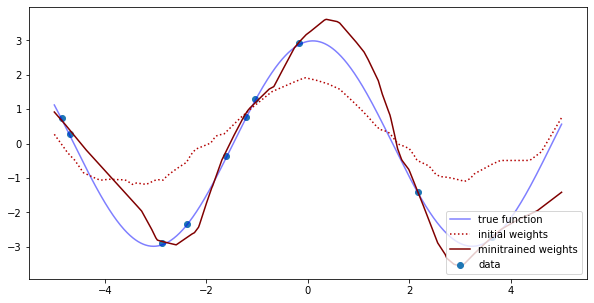

In [98]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[1.0414388179779053, 3.8586201667785645, 0.3232850134372711, 0.3306262791156769, 1.005326509475708, 3.2523887157440186, 2.821871519088745, 1.6098893880844116, 0.0818093791604042, 0.06350484490394592]


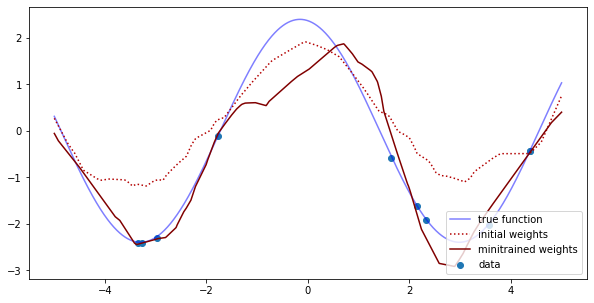

In [96]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[1.1733028888702393, 1.08505117893219, 0.22311362624168396, 0.19139543175697327, 0.5204752683639526, 2.0038437843322754, 6.688040256500244, 7.449194431304932, 1.6861969232559204, 0.7142587304115295]


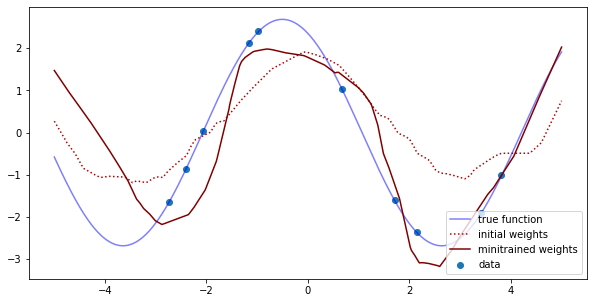

In [88]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

## Gaussian, 50000 epochs, 0.1, 5, 0, np.pi, -5, 5 - marche très mal

De manière générale pour le Gaussien, surtout si la fonction à apprendre est simple (i.e. un des paramètres, variance ou moyenne ne varie pas), maml a de bien meilleurs résultats avec très peu de points pour le few-shots (moins de 10).

In [ ]:
plt.plot(maml.meta_losses)

## Gaussian, 50000 epochs, 0, 2, -1, 1, -5, 5

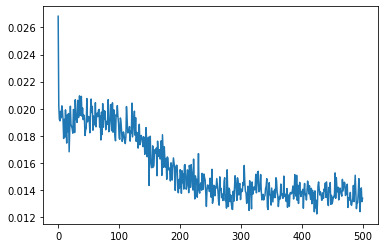

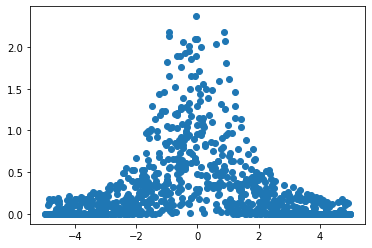

Facilement beaucoup d'overfit

In [ ]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

In [ ]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

## Distribution de la fonction

On choisit ici la fonction que l'on utilise, c'est important !

In [126]:
def function(amp, phase, x):
    return amp*np.sin(phase+x)

#generating data
class FunctionTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp  #Amplitude
    
    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_function(x) + noise(epsilon)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y
  
    def true_function(self,x):
        y = function(self.amp, self.phase, x)
        return y
    
class FunctionDistribution():
    def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
        self.min_amp=min_amp
        self.max_phase=max_phase
        self.min_phase=min_phase
        self.max_amp=max_amp
        self.min_x=min_x  #Pas de changement par rapport à précédemment
        self.max_x=max_x  #Pas de changement par rapport à précédemment
    
    def sample_task(self):
        amp = np.random.uniform(self.min_amp, self.max_amp)
        phase = np.random.uniform(self.min_phase, self.max_phase)
        return FunctionTask(amp, phase, self.min_x, self.max_x)

## Algorithme du MAML

In [110]:
#defining our neural network
class FNet(nn.Module):
  def __init__(self):
    super(FNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

class FMAML():
  def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
    self.net=net
    self.weights=list(net.parameters())
    self.alpha=alpha
    self.beta=beta
    self.tasks=tasks
    self.k=k 
    self.num_tasks_meta=num_metatasks #nombre de tâches que l'on utilise
    self.criterion=nn.MSELoss()  #criterion just to chose
    self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
    self.meta_losses=[]
    self.plot_every =100
    self.print_every = 1000
    self.num_metatasks=num_metatasks

  def inner_loop(self,task):
    temp_weights=[w.clone() for w in self.weights]
    x,y=task.sample_data(size=self.k) #sampling D
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    loss=self.criterion(output,y)/self.k
    grads=torch.autograd.grad(loss,temp_weights)
    temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
    x,y=task.sample_data(size=self.k) #sampling D'
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    metaloss=self.criterion(output,y)/self.k
    return metaloss
  
  def outer_loop(self,num_epochs):
    total_loss=0
    for epoch in range(1,num_epochs+1): #Correspond au "While not done"
      metaloss_sum=0
      for i in range(self.num_metatasks): 
        task=self.tasks.sample_task()
        metaloss=self.inner_loop(task)
        metaloss_sum+=metaloss
      metagrads=torch.autograd.grad(metaloss_sum,self.weights)
      #important step
      for w,g in zip(self.weights,metagrads):
        w.grad=g
      ###############
      self.meta_optimiser.step()
      total_loss+=metaloss_sum.item()/self.num_metatasks
      if epoch % self.print_every == 0:
        print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
      if epoch%self.plot_every==0:
        self.meta_losses.append(total_loss/self.plot_every)
        total_loss = 0